
Generating IID samples from the bimodal posterior...

Running MCMC sampling...
Sampling with Metropolis using 4 chains...


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [x]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


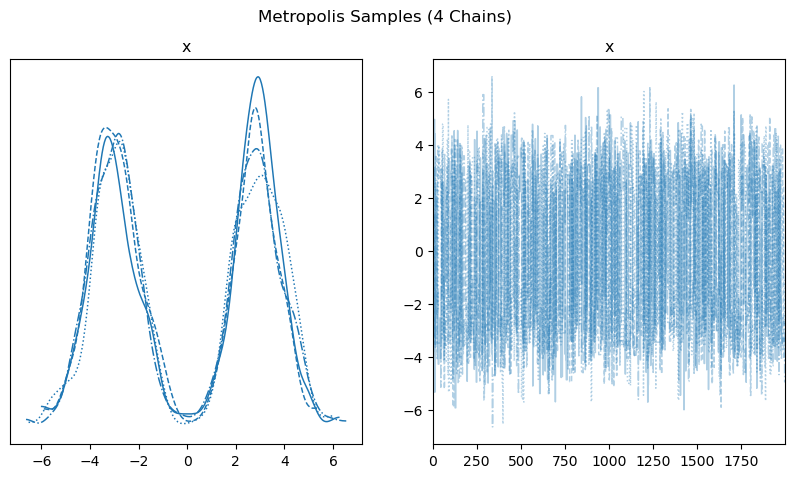

Sampling with DEMetropolis using 4 chains...


Population sampling (4 chains)
DEMetropolis: [x]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Output()

Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


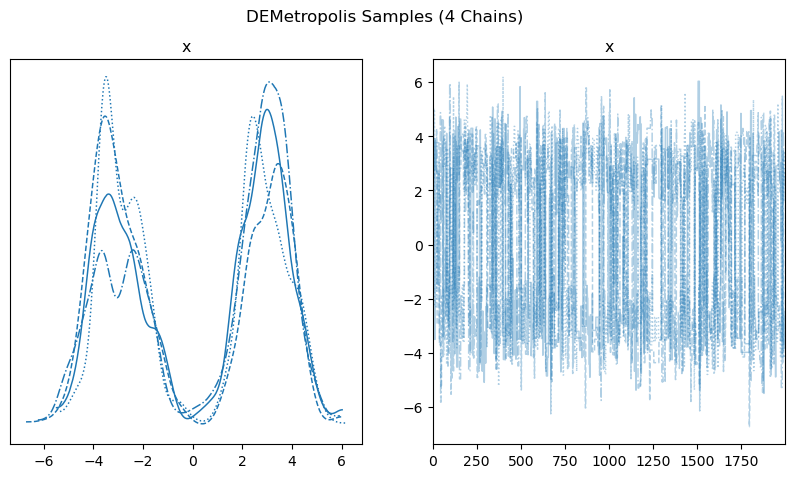

Sampling with HMC using 4 chains...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


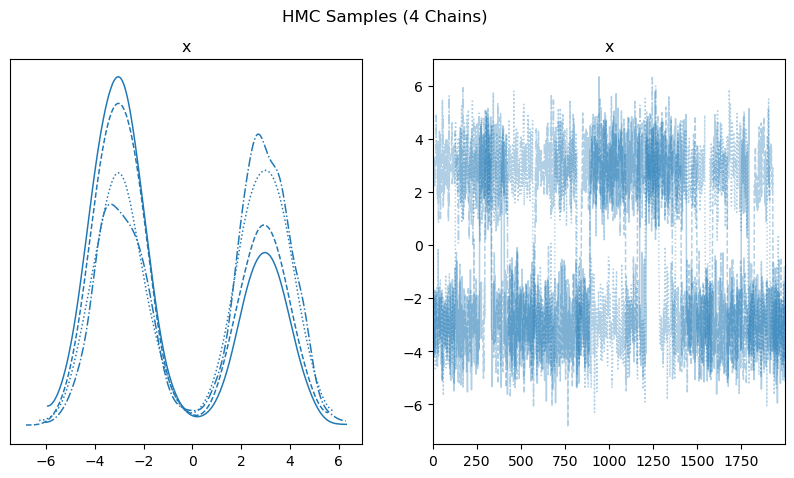


Computing pairwise Wasserstein distances...

Sampler 1       Sampler 2       Wasserstein Distance
Metropolis      DEMetropolis    0.21748             
Metropolis      HMC             0.29968             
Metropolis      IID             0.07269             
DEMetropolis    HMC             0.48589             
DEMetropolis    IID             0.16969             
HMC             IID             0.35461             

Ranking MCMC Samplers by Distance to IID Samples:

Rank  Sampler         Wasserstein Distance to IID
1     Metropolis      0.07269             
2     DEMetropolis    0.16969             
3     HMC             0.35461             


In [4]:
import numpy as np
import pymc as pm
import arviz as az
import scipy.stats as sp
import matplotlib.pyplot as plt
import itertools

class WassersteinExample:
    
    def __init__(self):
        self.model = self._bimodal_posterior()
    
    def _bimodal_posterior(self):        
        with pm.Model() as model:
            x = pm.Uniform("x", lower=-20, upper=20)  # Uniform prior to define domain
            pm.Potential("bimodal", np.log(np.exp(-0.5 * (x - 3) ** 2) + np.exp(-0.5 * (x + 3) ** 2)))
        return model

    def generate_iid_samples(self, num_samples=2000):
        """
        Generate IID samples from the bimodal posterior directly.
        """
        print("\nGenerating IID samples from the bimodal posterior...\n")

        # Flip a coin to choose which Gaussian to sample from
        modes = np.random.choice([-3, 3], size=num_samples)
        
        # Sample from N(mode, 1)
        iid_samples = np.random.normal(loc=modes, scale=1, size=num_samples)

        return iid_samples

    def run_sampling(self, num_samples=2000, tune=1000, num_chains=2):
        """
        Run MCMC sampling using different samplers, allowing multiple chains per method.
        """
        traces = {}

        with self.model:
            print("Running MCMC sampling...")

            methods = {
                "Metropolis": pm.Metropolis(),
                "DEMetropolis": pm.DEMetropolis(),
                "HMC": pm.NUTS(),
            }

            for method_name, sampler in methods.items():
                print(f"Sampling with {method_name} using {num_chains} chains...")
                trace = pm.sample(num_samples, tune=tune, step=sampler, chains=num_chains, return_inferencedata=True, progressbar=True)
                traces[method_name] = trace
                az.plot_trace(trace, figsize=(10, 5))
                plt.suptitle(f"{method_name} Samples ({num_chains} Chains)")
                plt.show()
        
        return traces

    def compute_wasserstein_distances(self, traces, iid_samples):
        """
        Compute pairwise Wasserstein distances between all MCMC samplers.
        Also compares each sampler against IID reference samples.
        """
        print("\nComputing pairwise Wasserstein distances...\n")

        # Extract samples and flatten across all chains
        samples = {
            method: traces[method].posterior["x"].values.flatten()
            for method in traces
        }
        samples["IID"] = iid_samples  # Add IID samples to the dictionary

        # Store Wasserstein distances
        wasserstein_distances = {}

        for (method1, method2) in itertools.combinations(samples.keys(), 2):
            distance = sp.wasserstein_distance(samples[method1], samples[method2])
            wasserstein_distances[(method1, method2)] = distance

        # Print results in a formatted table
        print(f"{'Sampler 1':<15} {'Sampler 2':<15} {'Wasserstein Distance':<20}")
        print("="*50)
        for (m1, m2), dist in wasserstein_distances.items():
            print(f"{m1:<15} {m2:<15} {dist:<20.5f}")

        # Rank samplers by distance to IID samples
        print("\nRanking MCMC Samplers by Distance to IID Samples:\n")

        iid_distances = {method: wasserstein_distances[(method, "IID")] for method in samples.keys() if method != "IID"}
        
        # Sort by smallest distance
        ranked_methods = sorted(iid_distances.items(), key=lambda x: x[1])

        print(f"{'Rank':<5} {'Sampler':<15} {'Wasserstein Distance to IID'}")
        print("="*50)
        for rank, (method, dist) in enumerate(ranked_methods, 1):
            print(f"{rank:<5} {method:<15} {dist:<20.5f}")

        return wasserstein_distances, ranked_methods


# Instantiate framework
framework = WassersteinExample()

# Generate IID samples
iid_samples = framework.generate_iid_samples()

# Run MCMC sampling with multiple chains (e.g., num_chains=4)
traces = framework.run_sampling(num_chains=4)

# Compute Wasserstein distances and rank samplers
wasserstein_results, ranked_methods = framework.compute_wasserstein_distances(traces, iid_samples)
